test

In [23]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image  
import random
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', max_images_per_class=200):
        """
        Args:
            root_dir (str): Directory containing the dataset.
            transform (callable, optional): Optional transform to be applied on an image.
            split (str): Which part of the dataset to use ('train' or 'val').
            max_images_per_class (int, optional): Limit the number of images per class.
                                                   If None, uses all images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.max_images_per_class = max_images_per_class
        self.images = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))  # Get sorted class names (diseases)
        self.class_map = {cls: idx for idx, cls in enumerate(self.classes)}  # Map class names to labels

        # Prepare images and labels based on class directories
        for class_name in self.classes:
            class_folder = os.path.join(root_dir, class_name)
            all_images = os.listdir(class_folder)

            # If max_images_per_class is specified, take only the first `max_images_per_class` images
            if self.max_images_per_class:
                random.shuffle(all_images)  # Shuffle to ensure randomness
                selected_images = all_images[:self.max_images_per_class]
            else:
                selected_images = all_images  # Take all images if no limit is set

            for img_name in selected_images:
                img_path = os.path.join(class_folder, img_name)
                self.images.append(img_path)
                self.labels.append(self.class_map[class_name])

        # Split data into train and validation sets
        train_images, val_images, train_labels, val_labels = train_test_split(self.images, self.labels, test_size=0.2, random_state=42)

        if self.split == 'train':
            self.images = train_images
            self.labels = train_labels
        else:
            self.images = val_images
            self.labels = val_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


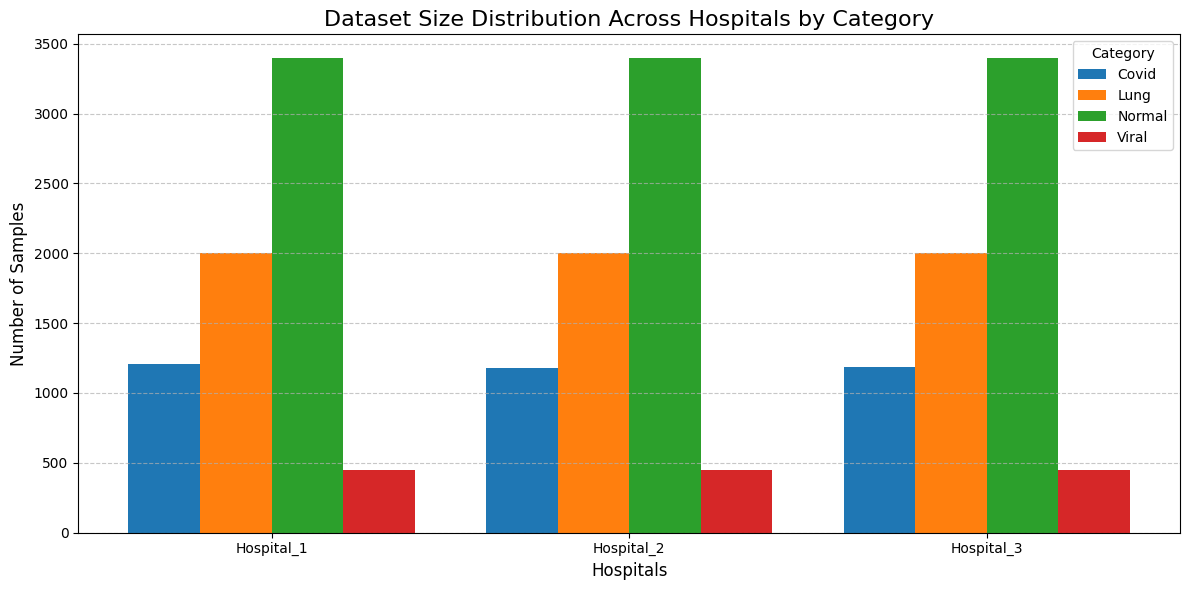

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data for hospital dataset sizes
hospital_data = {
    "Hospital_1": {"covid": 1205, "lung": 2004, "normal": 3398, "viral": 447},
    "Hospital_2": {"covid": 1177, "lung": 2004, "normal": 3397, "viral": 446},
    "Hospital_3": {"covid": 1188, "lung": 2004, "normal": 3396, "viral": 445},
}

# Prepare data for plotting
hospitals = list(hospital_data.keys())
categories = list(hospital_data["Hospital_1"].keys())

# Bar width and x locations
bar_width = 0.2
x = np.arange(len(hospitals))  # Base positions for hospitals

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Generate bars for each category
for idx, category in enumerate(categories):
    category_values = [hospital_data[h][category] for h in hospitals]
    ax.bar(x + idx * bar_width, category_values, bar_width, label=category.capitalize())

# Customize the plot
ax.set_title("Dataset Size Distribution Across Hospitals by Category", fontsize=16)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.set_xlabel("Hospitals", fontsize=12)
ax.set_xticks(x + bar_width * (len(categories) - 1) / 2)
ax.set_xticklabels(hospitals)
ax.legend(title="Category", fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [32]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Path to your dataset
hospitals_root = 'Hospitals_Dataset'
hospital_dirs = [os.path.join(hospitals_root, f'Hospital_{i+1}') for i in range(3)]  # assuming you have 3 hospitals

# Create data loaders for each hospital (client) with separate training and validation sets
hospital_train_loaders = []
hospital_val_loaders = []

for hospital_dir in hospital_dirs:
    # Create training and validation datasets for each hospital
    dataset_train = CustomDataset(hospital_dir, transform=transform, split='train')
    dataset_val = CustomDataset(hospital_dir, transform=transform, split='val')

    # Create data loaders for training and validation sets
    train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
    val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

    hospital_train_loaders.append(train_loader)
    hospital_val_loaders.append(val_loader)


In [35]:
# Define model architecture
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # Load a pretrained ResNet18 model
        self.model = models.resnet18(pretrained=True)
        
        # Modify the fully connected layer to include dropout
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # 512 hidden units
            nn.BatchNorm1d(512),
            nn.ReLU(),  # Activation function
            nn.Dropout(0.2),  # Dropout with 20% probability
            nn.Linear(512, num_classes)  # Output layer for classification
        )
    def forward(self, x):
        return self.model(x)


In [36]:
# Initialize models and optimizers for each hospital
client_models = [CNNModel(num_classes=len(os.listdir(hospital_dirs[0]))) for _ in range(3)]  # Assuming same number of classes across hospitals
client_models = [model.to(device) for model in client_models]
optimizers = [optim.SGD(model.parameters(), lr=0.01, momentum=0.9) for model in client_models]



c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# Modify the client_update function to include validation
def client_update(model, optimizer, train_loader, val_loader, epoch=1):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    # Train loop
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    #print(f"Epoch {epoch} training completed. Average loss: {average_loss:.4f}")

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        validation_accuracy = correct / total
    #print(f"Epoch {epoch} validation accuracy: {validation_accuracy:.4f}")

    return average_loss, validation_accuracy



In [38]:
# Aggregation function (simple averaging of model weights)
def server_aggregate(global_model, client_models, hospital_train_loaders):
    # Compute weights based on dataset sizes
    weights = [len(loader.dataset) for loader in hospital_train_loaders]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Initialize global model state
    global_state = global_model.state_dict()
    for key in global_state.keys():
        global_state[key] = sum(weights[i] * client_models[i].state_dict()[key] for i in range(len(client_models)))

    # Update global model
    global_model.load_state_dict(global_state)



In [39]:
def test(model, hospital_val_loaders):
    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for val_loader in hospital_val_loaders:
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

    accuracy = correct / total
    return loss.item(), accuracy


In [40]:
%%time
# Federated training loop
global_model = CNNModel(num_classes=len(os.listdir(hospital_dirs[0]))).to(device)
num_rounds = 10  # Federated learning rounds
epochs = 10  # Number of local epochs per client

for round in range(num_rounds):
    print(f"------------------Round {round + 1}/{num_rounds}--------------------------")

    # Train on each hospital's dataset (client-specific training)
    for client_idx, (train_loader, val_loader) in enumerate(zip(hospital_train_loaders, hospital_val_loaders)):
        print(f"Training on Hospital {client_idx + 1}")
        for epoch in range(1, epochs + 1):
            loss, val_accuracy = client_update(client_models[client_idx], optimizers[client_idx], train_loader, val_loader, epoch=epoch)
        print(f"Validation accuracy for Hospital {client_idx + 1}: {val_accuracy:.4f}")

    # Aggregate the models with weighted averaging (after all clients' updates)
    server_aggregate(global_model, client_models, hospital_train_loaders)
    print(f"Aggregated global model after round {round + 1}")

    # Compute global validation accuracy for the aggregated global model
    global_val_loss, global_val_accuracy = test(global_model, hospital_val_loaders)
    print(f"Aggregated global validation loss: {global_val_loss:.4f}, global validation accuracy: {global_val_accuracy:.4f}")


------------------Round 1/10--------------------------
Training on Hospital 1
Validation accuracy for Hospital 1: 0.8750
Training on Hospital 2
Validation accuracy for Hospital 2: 0.9187
Training on Hospital 3
Validation accuracy for Hospital 3: 0.8688
Aggregated global model after round 1
Aggregated global validation loss: 0.8423, global validation accuracy: 0.8854
------------------Round 2/10--------------------------
Training on Hospital 1
Validation accuracy for Hospital 1: 0.9313
Training on Hospital 2
Validation accuracy for Hospital 2: 0.8750
Training on Hospital 3
Validation accuracy for Hospital 3: 0.8875
Aggregated global model after round 2
Aggregated global validation loss: 0.8546, global validation accuracy: 0.8083
------------------Round 3/10--------------------------
Training on Hospital 1
Validation accuracy for Hospital 1: 0.9187
Training on Hospital 2
Validation accuracy for Hospital 2: 0.9062
Training on Hospital 3
Validation accuracy for Hospital 3: 0.9313
Aggregate

In [41]:
def metrics(model, hospital_val_loaders):
    model.eval()
    all_targets = []
    all_predictions = []
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for val_loader in hospital_val_loaders:
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                _, predicted = torch.max(output, 1)
                
                # Collect predictions and targets
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
                total += target.size(0)
                correct += (predicted == target).sum().item()

    accuracy = correct / total

    # Compute additional metrics
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    cm = confusion_matrix(all_targets, all_predictions)

    

    # Define class labels
    class_labels = hospital_train_loaders[0].dataset.classes

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)

    # Customize plot
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()

    # Display the plot
    plt.show()
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return loss.item(), accuracy

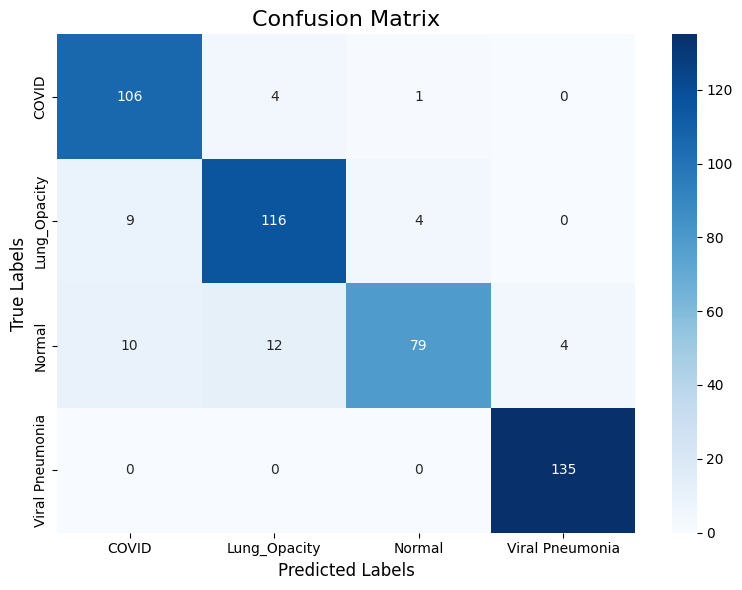

Precision: 0.9112, Recall: 0.9083, F1-Score: 0.9066
Aggregated global validation loss: 0.7245, global validation accuracy: 0.9083


In [42]:
global_val_loss, global_val_accuracy = metrics(global_model, hospital_val_loaders)
print(f"Aggregated global validation loss: {global_val_loss:.4f}, global validation accuracy: {global_val_accuracy:.4f}")

In [43]:

model_save_path = 'global_model.pth'
torch.save(global_model.state_dict(), model_save_path)
print(f"Global model saved to {model_save_path}")

Global model saved to global_model.pth
